In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Activation, GlobalMaxPool2D
from keras.optimizers import SGD
import time
import datetime

%matplotlib inline
np.set_printoptions(linewidth=120)
plt.rcParams['figure.figsize'] = (19, 13)

Using TensorFlow backend.


# Problem Formulation

The dataset consists of 1042 shot gathers before and after AAA, represented as color images. We would like to train a convolutional neural network to perform binary classification.

The features (X) are the 621 by 512 color images and the prediction is whether there is too much signal leakage after AAA (FAIL = 0) or if it is acceptable (PASS = 1)

In [2]:
# read in data and store in RAM
path = 'D:/Projects/eh17_NAM/Machine_Learning/AAA_QC/numpy_data/'
tmp = np.load(path + 'RevXII_RawData.npz')

In [3]:
X_all = tmp['X_raw_all']
print(X_all.shape)

Y_all = tmp['Y_all']
print(Y_all.shape)

shot_id = tmp['shot_id']
print(shot_id.shape)

print(4*np.product(X_all[0].shape)/1024/1024, 'MB per shot')

(1042, 621, 512, 3)
(1042,)
(1042,)
3.638671875 MB per shot


In [4]:
shot_id[:10]

array([19576, 19580, 19584, 19588, 19592, 19596, 19600, 19604, 19608, 19612])

# Step 1a Define Weights to Overcome Class Imbalance

The dataset consists of 1042 shot gathers before and after AAA, represented as color images. We would like to train a convolutional neural network to perform binary classification.

The features (X) are the 621 by 512 color images and the prediction is whether there is too much signal leakage after AAA (FAIL = 0) or if it is acceptable (PASS = 1)

In [5]:
np.sum(Y_all)/len(Y_all)

0.78502879078694821

Only about 22% of shots are marked as FAIL, ideally it's better to train model with 50-50 datasets. This is a common occurence and it is known in the literature as Class Imbalance

There are many ways to handle this but the way we do it here is to weigh the minority class higher in training

In [6]:
# compute weights to normalize class imbalance
W_all = np.zeros_like(Y_all).astype(np.int)
W_all[Y_all == 0] = 3
W_all += 1

# Step 1b Define Convolutional Neural Network

Rather than training a model from scratch, we will be using a trained ConvNet called VGG16 (actually just the first two blocks) and stitch a few layers of untrained neural networks to it.


Note that the final layer is a single neuron outputting values from 0 to 1

In [10]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.cs.toronto.edu/~frossard/post/vgg16/vgg16.png", width=1200)

In [7]:
# stitch layers to the VGG16 layers
orig_VGG16 = VGG16(weights='imagenet', include_top=False)

num_filters = 64
dropout_prob = 0.55
x = orig_VGG16.get_layer('block2_pool').output
x = Conv2D(num_filters, (1, 1), activation='relu', padding='same', name='block6_conv1')(x)
x = GlobalMaxPool2D(name='block6_pool')(x)
x = Dropout(dropout_prob)(x)

x = Dense(num_filters)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(dropout_prob)(x)

prediction = Dense(1, activation='sigmoid')(x)
model = Model(inputs=orig_VGG16.input, outputs=prediction)

# Step 1c Train Fresh Layers

The training will be done in several stages. First, we freeze all the layers from VGG16 (i.e. the weights in those layers will not be updated) and just train the newly added layers.

In [8]:
# freeze original VGG16 layers
for i, layer in enumerate(model.layers):
    if 'block1' in layer.name or 'block2' in layer.name:
        layer.trainable = False
    else:
        layer.trainable = True

    print(i, layer.trainable, layer.name)

model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary(line_length=100)

0 True input_1
1 False block1_conv1
2 False block1_conv2
3 False block1_pool
4 False block2_conv1
5 False block2_conv2
6 False block2_pool
7 True block6_conv1
8 True block6_pool
9 True dropout_1
10 True dense_1
11 True batch_normalization_1
12 True activation_1
13 True dropout_2
14 True dense_2
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_1 (InputLayer)                         (None, None, None, 3)                   0              
____________________________________________________________________________________________________
block1_conv1 (Conv2D)                        (None, None, None, 64)                  1792           
____________________________________________________________________________________________________
block1_conv2 (Conv2D)                        (None, None, None, 64)                  36928        

Start training the ConvNet!!

**WARNING** This will take many hours on the CPU. Will be much faster if running on GPU

In [9]:
model.fit(X_all, Y_all, batch_size=32, epochs=60, verbose=2, shuffle=True, validation_split=0.3, sample_weight=W_all);

Train on 729 samples, validate on 313 samples
Epoch 1/60
1079s - loss: 1.4891 - val_loss: 1.9849
Epoch 2/60
1083s - loss: 1.3194 - val_loss: 1.7208
Epoch 3/60
1075s - loss: 1.2994 - val_loss: 1.3529
Epoch 4/60
1076s - loss: 1.2591 - val_loss: 1.2548
Epoch 5/60
1063s - loss: 1.2758 - val_loss: 1.1600
Epoch 6/60
1064s - loss: 1.2457 - val_loss: 1.0616
Epoch 7/60
1064s - loss: 1.2050 - val_loss: 1.0347
Epoch 8/60
1063s - loss: 1.1406 - val_loss: 0.9967
Epoch 9/60
1066s - loss: 1.1961 - val_loss: 0.9663
Epoch 10/60
1060s - loss: 1.1504 - val_loss: 0.9240
Epoch 11/60
1061s - loss: 1.1129 - val_loss: 0.9172
Epoch 12/60
1062s - loss: 1.1490 - val_loss: 0.9040
Epoch 13/60
1064s - loss: 1.1378 - val_loss: 0.8812
Epoch 14/60
1063s - loss: 1.1091 - val_loss: 0.8729
Epoch 15/60
1064s - loss: 1.0869 - val_loss: 0.8598
Epoch 16/60
1066s - loss: 1.0434 - val_loss: 0.8487
Epoch 17/60
1063s - loss: 1.0962 - val_loss: 0.8476
Epoch 18/60
1063s - loss: 1.0204 - val_loss: 0.8511
Epoch 19/60
1067s - loss: 0

Plot the continuous confusion matrix and evaluate the *area under the receiver operating characteristic* or AUROC curve

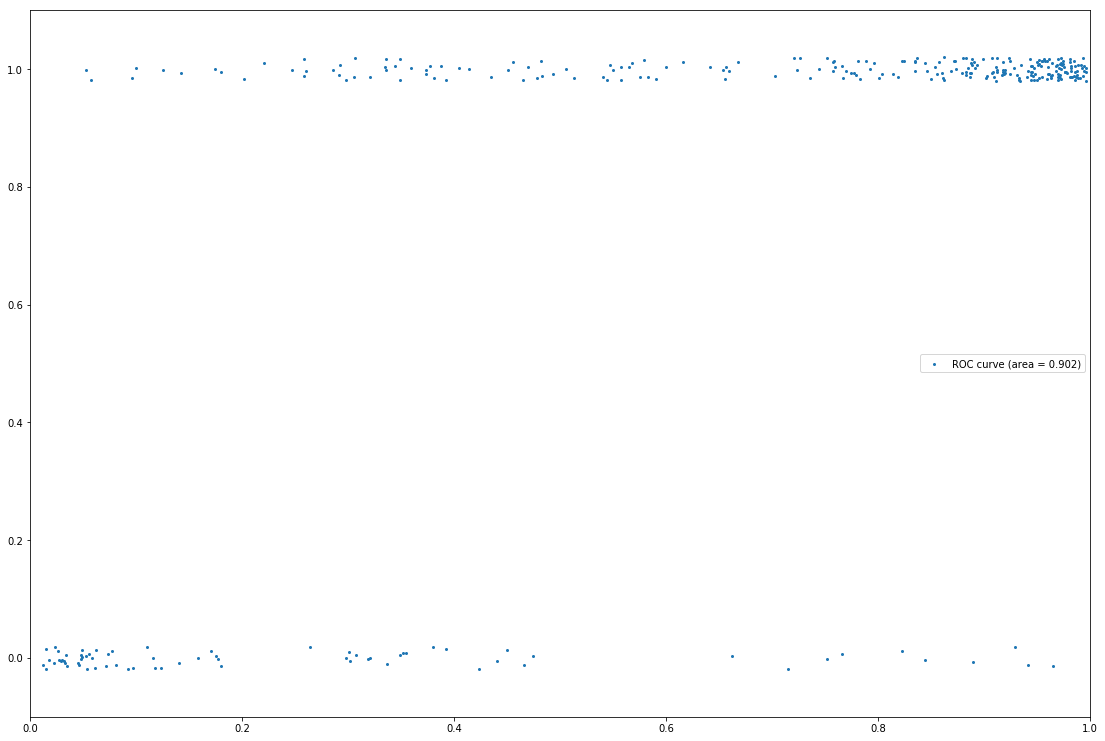

In [12]:
Y_predict = model.predict(X_all[-313:])
fpr, tpr, _ = metrics.roc_curve(Y_all[-313:], Y_predict)
plt.scatter(Y_predict, Y_all[-313:] + np.random.uniform(low=-0.02, high=0.02, size=313), s=4, label='ROC curve (area = %0.3f)' % metrics.auc(fpr, tpr));
plt.xlim([0.0, 1.0]); plt.ylim([-0.1, 1.1]); plt.legend(loc="center right")

**Observation**: The ConvNet achieved an AUROC of 0.902 out of a maximum of 1. Pretty good!

Write the trained weights to disk so we can backtrack if necessary

In [13]:
# save weights with timestamps
path = '//hona01a.houston-us0380.slb.com/ud/eh17/CNN_QC_Assistant_ee71/text_files/101_Migration_Preparation_T/'
file_name = 'model_weights/' + datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H_%M') + '.h5'
model.save_weights(path + file_name, overwrite=False)
print('Saved ConvNet weights: ' + path + file_name)

# Step 1d Train Fresh Layers and Second Block of VGG16

In this stage, we unfreeze the VGG16 block closest to the fully connected layers and train it together with the layers we trained in 1c.

In [16]:
# unfreeze block2
for i, layer in enumerate(model.layers):
    if 'block1' in layer.name:
        layer.trainable = False
    else:
        layer.trainable = True

    print(i, layer.trainable, layer.name)

model.compile(optimizer=SGD(lr=0.0002, momentum=0.9), loss='binary_crossentropy')
model.summary(line_length=100)

0 True input_1
1 False block1_conv1
2 False block1_conv2
3 False block1_pool
4 True block2_conv1
5 True block2_conv2
6 True block2_pool
7 True block6_conv1
8 True block6_pool
9 True dropout_1
10 True dense_1
11 True batch_normalization_1
12 True activation_1
13 True dropout_2
14 True dense_2
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_1 (InputLayer)                         (None, None, None, 3)                   0              
____________________________________________________________________________________________________
block1_conv1 (Conv2D)                        (None, None, None, 64)                  1792           
____________________________________________________________________________________________________
block1_conv2 (Conv2D)                        (None, None, None, 64)                  36928          


In [17]:
# fine-tune all layers while keeping block1 fixed
model.fit(X_all, Y_all, batch_size=32, epochs=12, verbose=2, shuffle=True, validation_split=0.3, sample_weight=W_all)

Train on 729 samples, validate on 313 samples
Epoch 1/12
1471s - loss: 0.4836 - val_loss: 0.6348
Epoch 2/12
1456s - loss: 0.4916 - val_loss: 0.6287
Epoch 3/12
1465s - loss: 0.4729 - val_loss: 0.6529
Epoch 4/12
1489s - loss: 0.4570 - val_loss: 0.6464
Epoch 5/12
1511s - loss: 0.4333 - val_loss: 0.6615
Epoch 6/12
1504s - loss: 0.4282 - val_loss: 0.6556
Epoch 7/12


KeyboardInterrupt: 

Didn't like that the validation loss is so high so I decided to kill the training job.



Next, load the saved weights to backtrack and tweak the training parameters a little. 

In [25]:
# backtrack by loading previously saved weights
path = '//hona01a.houston-us0380.slb.com/ud/eh17/CNN_QC_Assistant_ee71/text_files/101_Migration_Preparation_T/'
file_name = 'model_weights/20170815_13_13.h5'
model.load_weights(path + file_name)
print('Loaded ConvNet weights: ' + path + file_name)

Loaded ConvNet weights: //hona01a.houston-us0380.slb.com/ud/eh17/CNN_QC_Assistant_ee71/text_files/101_Migration_Preparation_T/model_weights/20170815_13_13.h5


In [26]:
# unfreeze block2 and dense layers
for i, layer in enumerate(model.layers):
    if 'block1' in layer.name:
        layer.trainable = False
    else:
        layer.trainable = True

    print(i, layer.trainable, layer.name)

model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy')
model.summary(line_length=100)

0 True input_1
1 False block1_conv1
2 False block1_conv2
3 False block1_pool
4 True block2_conv1
5 True block2_conv2
6 True block2_pool
7 True block6_conv1
8 True block6_pool
9 True dropout_1
10 True dense_1
11 True batch_normalization_1
12 True activation_1
13 True dropout_2
14 True dense_2
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_1 (InputLayer)                         (None, None, None, 3)                   0              
____________________________________________________________________________________________________
block1_conv1 (Conv2D)                        (None, None, None, 64)                  1792           
____________________________________________________________________________________________________
block1_conv2 (Conv2D)                        (None, None, None, 64)                  36928          


In [27]:
# fine-tune all layers while keeping block1 fixed
model.fit(X_all, Y_all, batch_size=32, epochs=6, verbose=2, shuffle=True, validation_split=0.3, sample_weight=W_all);

Train on 729 samples, validate on 313 samples
Epoch 1/6
1492s - loss: 0.6071 - val_loss: 0.7553
Epoch 2/6
1465s - loss: 0.5875 - val_loss: 0.6571
Epoch 3/6
1481s - loss: 0.6252 - val_loss: 0.6097
Epoch 4/6
1480s - loss: 0.5483 - val_loss: 0.7075
Epoch 5/6
1448s - loss: 0.5554 - val_loss: 0.6350
Epoch 6/6
1434s - loss: 0.5179 - val_loss: 0.6421


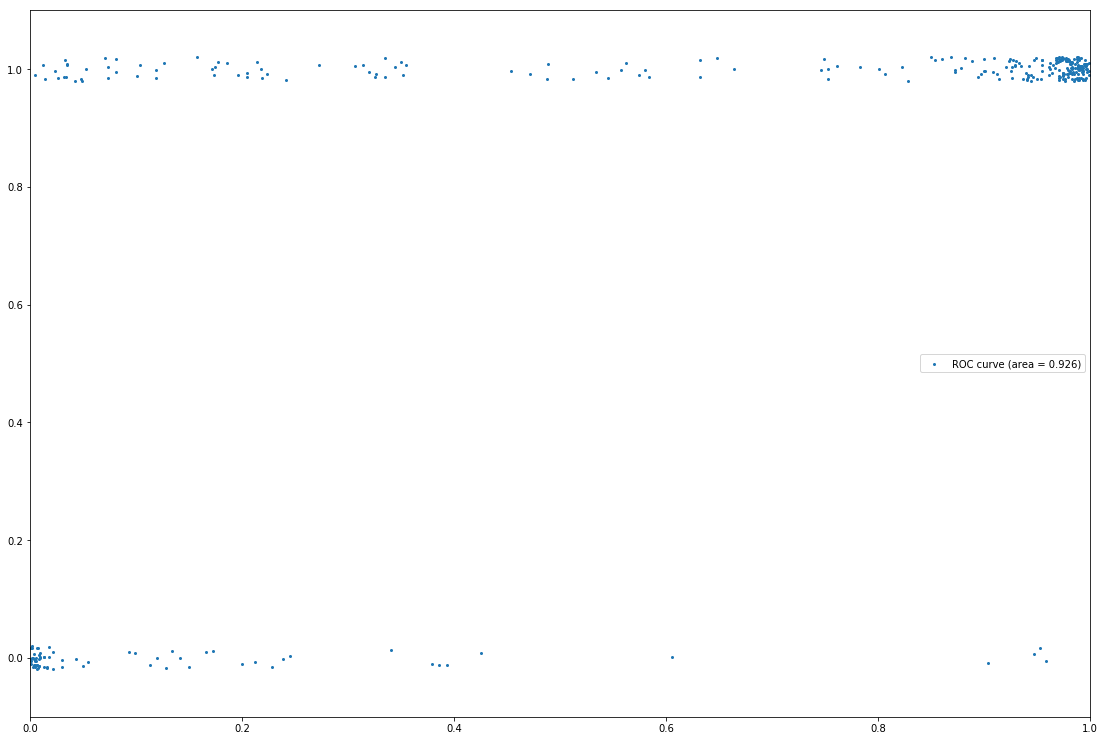

In [28]:
Y_predict = model.predict(X_all[-313:])
fpr, tpr, _ = metrics.roc_curve(Y_all[-313:], Y_predict)
plt.scatter(Y_predict, Y_all[-313:] + np.random.uniform(low=-0.02, high=0.02, size=313), s=4, label='ROC curve (area = %0.3f)' % metrics.auc(fpr, tpr));
plt.xlim([0.0, 1.0]); plt.ylim([-0.1, 1.1]); plt.legend(loc="center right");

**Observation**: The ConvNet went from AUROC of 0.902 to 0.926. Not bad at all!

We like this so we'll save the weights for posterity

In [29]:
# save weights with timestamps
path = '//hona01a.houston-us0380.slb.com/ud/eh17/CNN_QC_Assistant_ee71/text_files/101_Migration_Preparation_T/'
file_name = 'model_weights/' + datetime.datetime.fromtimestamp(time.time()).strftime('%Y%m%d_%H_%M') + '.h5'
model.save_weights(path + file_name, overwrite=False)
print('Saved ConvNet weights:' + path + file_name)

Saved ConvNet weights://hona01a.houston-us0380.slb.com/ud/eh17/CNN_QC_Assistant_ee71/text_files/101_Migration_Preparation_T/model_weights/20170816_13_33.h5


# Step 1e Train All Layers

Finally, unfreeze all the layers and train them all in one go.

In [31]:
# unfreeze all layers
for i, layer in enumerate(model.layers):
    layer.trainable = True

    print(i, layer.trainable, layer.name)

model.compile(optimizer=SGD(lr=0.0002, momentum=0.9), loss='binary_crossentropy')
model.summary(line_length=100)

0 True input_1
1 True block1_conv1
2 True block1_conv2
3 True block1_pool
4 True block2_conv1
5 True block2_conv2
6 True block2_pool
7 True block6_conv1
8 True block6_pool
9 True dropout_1
10 True dense_1
11 True batch_normalization_1
12 True activation_1
13 True dropout_2
14 True dense_2
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
input_1 (InputLayer)                         (None, None, None, 3)                   0              
____________________________________________________________________________________________________
block1_conv1 (Conv2D)                        (None, None, None, 64)                  1792           
____________________________________________________________________________________________________
block1_conv2 (Conv2D)                        (None, None, None, 64)                  36928          
___

In [32]:
# fine-tune all layers while keeping block1 fixed
model.fit(X_all, Y_all, batch_size=32, epochs=4, verbose=2, shuffle=True, validation_split=0.3, sample_weight=W_all);

Train on 729 samples, validate on 313 samples
Epoch 1/4
2080s - loss: 0.5723 - val_loss: 0.6936
Epoch 2/4
2052s - loss: 0.4930 - val_loss: 0.6570
Epoch 3/4
2023s - loss: 0.4665 - val_loss: 0.6273
Epoch 4/4
2028s - loss: 0.5018 - val_loss: 0.6407


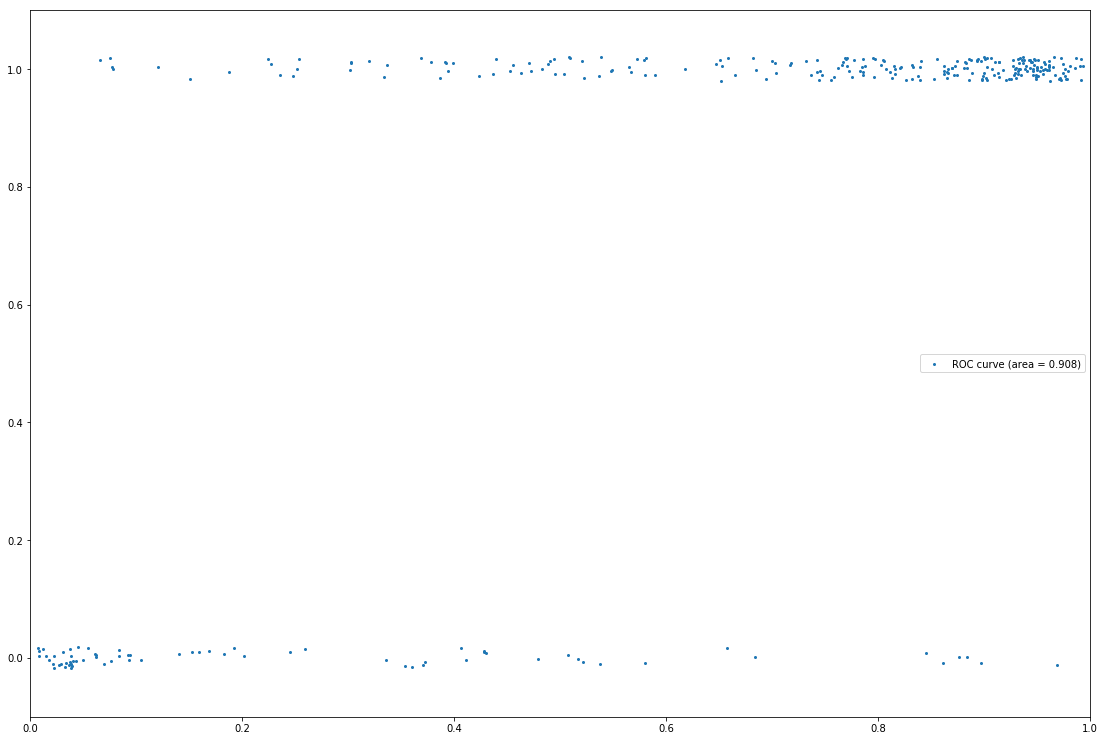

In [33]:
Y_predict = model.predict(X_all[-313:])
fpr, tpr, _ = metrics.roc_curve(Y_all[-313:], Y_predict)
plt.scatter(Y_predict, Y_all[-313:] + np.random.uniform(low=-0.02, high=0.02, size=313), s=4, label='ROC curve (area = %0.3f)' % metrics.auc(fpr, tpr));
plt.xlim([0.0, 1.0]); plt.ylim([-0.1, 1.1]); plt.legend(loc="center right");

This round of training actually produced a worse AUROC. Maybe the training parameters are not optimal. Good thing we can backtrack!